# Community detection - workshop spectral clustering

In this workshop we will look at solving the problem of community detection using **spectral clustering**. The term *clustering* refers to the fact that nodes will be mapped to coordinates in some $m$-dimensional space, where $m$ is the number of communities. Then nodes are placed in the same community depending on their proximity in this space. The mapping of nodes to the space is done using the *spectrum* (eigenvalues and eigenvectors) of some matrix associated with the graph. In particular we will consider the *Laplacian matrix*.

## Laplacian matrix

Consider a graph $G$ of size $n$ with non-negative edge weights $w_{ij} > 0$. We can then define the *adjacency weight matrix* $W \in \mathbb{R}_+^{n \times n}$ to denote every pair of vertices $(i,j)$ the weight of the edge from $i$ to $j$, if it exists. That is 

$$W_{ij} = \begin{cases} w_{ij} &\text{if } A_{ij} = 1,\\ 0 &\text{else.} \end{cases}$$

We also define the matrix $D \in \mathbb{N}^{n \times n}$ as follows

$$D_{ij} = \begin{cases} \sum_{j = 1}^n w_{ij} &\text{if } i = j,\\ 0 &\text{else.} \end{cases}$$

With this setup we define the *Laplacian matrix* as $L = D - W$. 

## Spectrum

The spectrum of any matrix $B$ is determined by the collection of *eigenvectors* and *eigenvalues*. These are the collections of vectors $v$ and values $\lambda$ that satisfy the equation $B v = \lambda v$.

For commumity detection we will focus on the spectrum of the *Laplacian matrix* and its normalized cousins. For a graph of size $n$ we have $n$ eigenvectors $v_1, \dots, v_n$ and $n$ eigenvalues $\lambda_1, \dots, \lambda_n$. Please note that the eigenvalues are not necessarily distinct. An important property of the laplacian matrices is that their eigenvectors are real-valued and their eigenvalues are non-negative real-valued.

As mentioned above, the idea behind spectral clustering is to map nodes to positions in an $m$-dimensional space. This simply means that we need a vector $x_i \in \mathbb{R}^m$ for each node $i$. For this we can use the eigenvectors of the Laplacian matrices. 

For a fixed $m$ this works as follows:
1. Compute the $m$ smallest eigen values $\lambda_1 \le \lambda_2 \le \dots \le \lambda_m$ and associated eigenvectors $v_1, \dots, v_m$.
2. For each node $1 \le i \le n$ let $x_i = [v_i(1), v_i(2), \dots, v_i(m)]$ (the i-th row of v_1 -- v_m).

We can then plot the positions of the nodes in $m$-dimensional space.

To implement this in Python we make use of NetworkX for getting the matrices and then use the `eigs` function from the `scipy.sparse.linalg` library. This function computes the spectrum of sparse matrices. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html for more details.

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
import numpy as np

To demonstrate how these functions work we consider the graph in `graph_with_communities_spectral_1.gz`. This consist of two disjoint Erdos-Renyi graphs of 100 nodes.

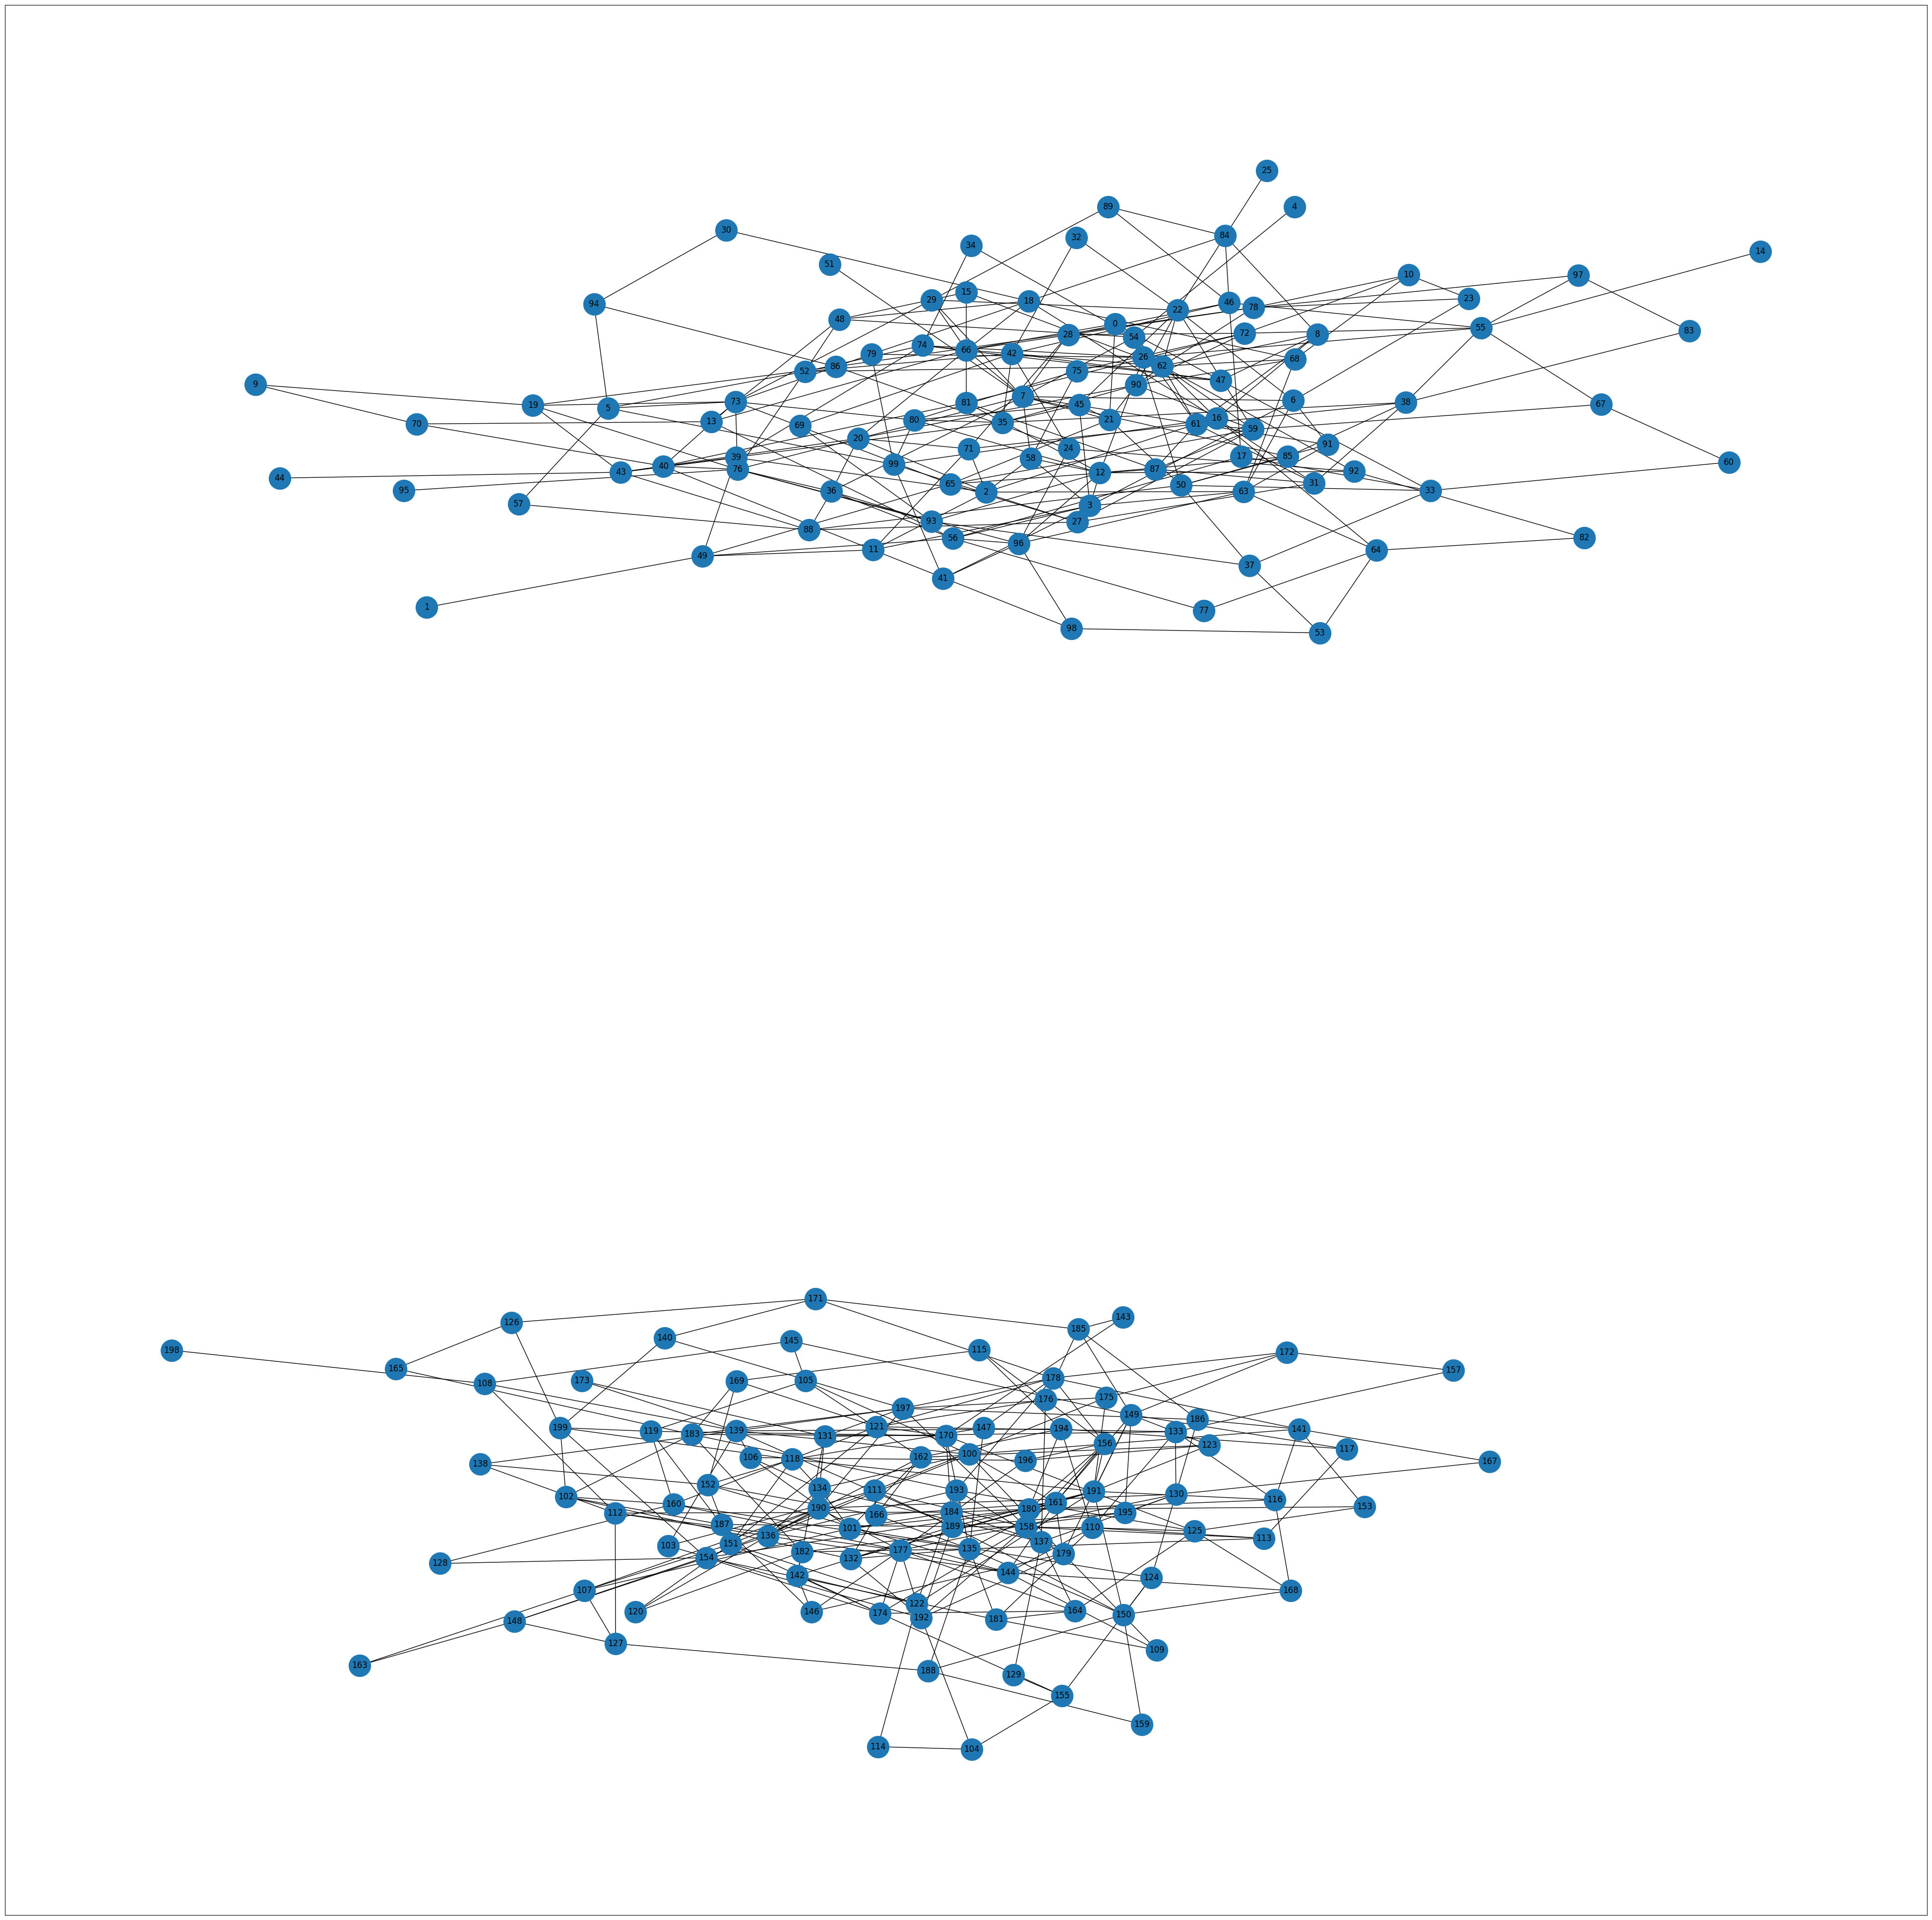

In [9]:
disjoint_graph = nx.read_multiline_adjlist('datasets/graph_with_communities_spectral_1.gz')

fig = plt.figure(figsize=(50,50))

nx.draw_networkx(disjoint_graph,node_size=1000)

We now compute the Laplacian matrix using the `laplacian_matrix` function from NetworkX.

In [12]:
L_disjoint = nx.laplacian_matrix(disjoint_graph)

To keep the Notebook clean we will supress warnings from now on.

In [13]:
import warnings
warnings.filterwarnings("ignore")

We now move on to compute the spectrum of the laplacian matrix `L_disjoint` using the `eigs` functions. To use this function we must first map the matrix entries to float type using `asftype`. Then we compute the first 2 eigenvalues and corresponding eigenvectors with the smallest real-part. For the latter we need to specify the `which` parameter to `'SR'`.

In [14]:
M_disjoint = L_disjoint.asfptype()

vals_disjoint, vecs_disjoint = eigs(M_disjoint,2,which='SR')

It is important to note that by default the spectrum is represented using complex numbers. However, the complex part is zero because the the spectrum of the laplacian matrix is always real-valued. 

In [15]:
vals_disjoint

array([7.76701340e-16+0.j, 6.31945651e-16+0.j])

So we will first map them to real numbers using the numpy function `real`. Then we plot them using a scatter plot.

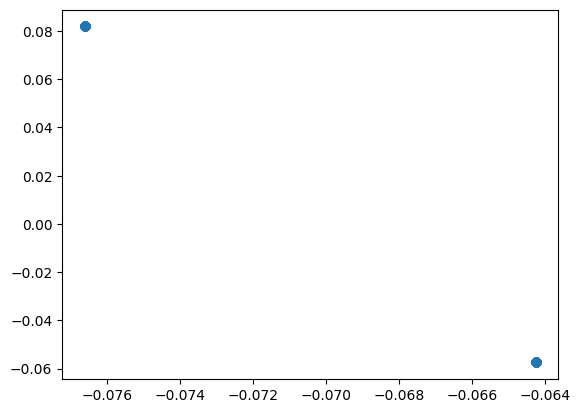

In [16]:
X_disjoint = np.real(vecs_disjoint)

fig = plt.figure()
plt.scatter(X_disjoint[:,0],X_disjoint[:,1])

We can clearly see that the all the nodes are mapped to one of two points. Each point corresponds to nodes in one of the two disjoint graphs. So in this case it is not difficult to identify the communities. However, in general things will not be so clear-cut.

**Exercise 1.** Load the graphs in `graph_with_communities_spectral_2` and `graph_with_communities_spectral_3`. For each of them plot the position of the nodes based on the smallest two eigenvalues of the laplacian matrix. What do you observe? Do these graphs have a community structure?

## Clustering nodes

We have seen that it is not always easy to cluster nodes manually using our eyes. So we need a more structured approach. Luckily there are many methods for *clustering* data points. In this Notebook we use the *k-means* method.

[Explain method]

Given a fix integer $m$ and the vectors $x_1, \dots, x_n \in \mathbb{R}^m$ for the nodes, the *k-means* methods assigns each vector to one of $m$ clusters such that some overal score is minimized. For a given assignment $C = \{C_1, \dots, C_m\}$ let $|C_k|$ denote the number of vectors assigned to community $C_k$ and define 

$$\mu_k = \frac{1}{|C_k|}\sum_{x \in C_k} x.$$

Then *k-means* finds the assignment that minimizes the following score:

$$\sum_{k = 1}^m \sum_{x \in C_k} \|x - \mu_k\|^2.$$

Again, we do not have to implement this algorithm from scratch because there are many Python implementations. In this Notebook we use the one from the `scikit learn` library called `KMeans`. For more information see https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html. 

To illustrate this function we apply it to the disjoint graph. Once the algorithm is run each of the $n$ nodes is assigned a label $\ell_i \in \{0,1, \dots, m-1\}$ such that $C_k = \{x_i : \ell_i = k-1\}$. We can then output these labels using the `labels_` command.

In [8]:
from sklearn.cluster import KMeans

# Initionalize k-means clustering algorithm
kmeans = KMeans(n_clusters=2)

# Apply algorithm to the eigenvectors
kmeans.fit(X_disjoint)

print(kmeans.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


As we can see, each node is pefectly assigned to one of two communities and these indeed correspond to the two disjoint graphs since the first graph has nodes $0,1, \dots, 99$.

Again, it should not be a surprise that this method works well on two disjoint graphs. And we might expect the method to work less and less if we started adding edges betweent the two components. We will see this in the next exercise.

**Exercise 2.** Create five different graphs $G_m$ where each graph is the disjoint graph with $m$ edges to nodes in the two components, selected uniformly at random, and $m \in \{0, 50,100,150,200\}$. For each $G_m$, compute the spectrum and perform k-means clustering. Plot the resulting vectors in the same figure, using different colors For $m \in \{0, 50,100,150,200\}$ and evaluate the spectral clustering results with the ground truth. What do you observe?

In [9]:
# Your answer goes here

The graph `graph_with_communities_3.gz` was created using a SBM with $N = \{100,80\}$ and $$P = \begin{pmatrix}
\frac{5}{100} &  \frac{1}{100} \\
   \frac{1}{100} & \frac{5}{80}
\end{pmatrix}.$$
So the communities should be $C_1 = \{0,1,\dots, 99\}$ and $C_2 = \{100,101,\dots,179\}$.

**Exercise 3.** Run spectral clustering on the graph `graph_with_communities_spectral_3`. Did it correctly identify the right communities. If not, which nodes where misclassified and why do you think that is the case?

In [36]:
# Your answer goes here

## Other matrices

In addition to the Laplacian matrix there are two other matrices that are often used for spectral clustering. These are sometimes referred to as a *normalized laplacian matrix* and are define as:

1. $L_{\rm sym} = D^{-1/2} L D^{-1/2}$ and
2. $L_{\rm rw} = D^{-1} L.$

The first matrix can be computed using the `normalized_laplacian_matrix` from the NetworkX library. When using this matrix in spectral clustering one more additional step has to be made. Once the $m$ eigenvectors are obtained, the coordinates of each vector $x_i$ have to be normalized as follows:

$$y_i = \frac{x_i}{\sqrt{\sum_{j=1}^m x_i(j)^2}}.$$

**Exercise 4.** Compute the first two eigenvectors of $L_{\rm sym}$ on `graph_with_communities_spectral_3.gz`. Give a scatter plot of both the unnormalized and normalized vectors. What differences do you observe? How do you think this might affect the outcome of k-means clustering?

In [61]:
# Your answer goes here

## How many communities?

One of the key problems with implementing spectral clustering is that we need to know upfront how many communities $m$ there are. This is because we need to know $m$ to select the smallest $m$ eigenvalues and eigenvectors. Moreover, the k-means clustering also needs $m$ as input. 

However, we might not always know how many communities we should expect in a given network. Chosing the wrong value of $m$ can have severe consequences for the outcomes of spectral clustering.

**Exercise 5.** Create a graph that consists of four disjoint Erdos-Renyi graphs, each with $n = 100$ and $p = 0.05$. Then run spectral clustering on it with $m \in \{1,2,3,4\}$ and evaluate the results. Which communities does the method detect? Is there any setting in which all communities are correctely identified? If not, then why?

In [ ]:
# Your answer goes here

The problem of picking the right number of communities actually presents itself twice in spectral clustering. First we need to compute the smallest $m_1$ eigenvalues and corresponding eigenvectors. Then we need to do a k-means clustering on $m_2$ clusters based on these eigenvectors. Of course, we always pick $m_1 = m_2$. But what happens if we do not?

**Exercise 6.** Use the graph from the previous exercise. Run the spectral clustering algorithm with different values of $m_1$ for computing the spectrum and $m_4$ for the k-mean clustering and evaluate the results. What do you observe?

In [ ]:
# Your answer goes here

There are many ways to deal with the problem of selecting the right number of communities. However, not much is known theoreticall about the different approaches. 

One such approach looks at the eigenvalues $\lambda_1 \le \lambda_2 \le \dots \le \lambda_n$ and finds the first eigenvalue such that the difference with the previous one is much larger than for all eigenvalues before it. 

To illustrate this we show the first 10 eigenvalues for the disjoint graph from the previous exercise, after we removed all nodes with degree 0.

In [75]:
# Remove isolated nodes from the graph
G.remove_nodes_from(list(nx.isolates(G)))

# Compute spectrum
L = nx.laplacian_matrix(G)
M = L.asfptype()
vals, vecs = eigs(M,15,which='SR')

Y = np.real(vals)

diff = np.ediff1d(Y)
print(Y)

[ 1.57004518e-15  8.83725066e-16 -2.86659874e-15 -1.50764799e-15
  4.91557305e-01  5.59072254e-01  5.75886942e-01  5.76893223e-01
  6.38085385e-01  6.66025387e-01  6.74627124e-01  7.09041912e-01
  7.16108882e-01  7.14665289e-01  7.43146268e-01]


Here we can clearly see that the first 4 eigenvalues are much smaller then those after it. Indicating that there might be 4 communities present.

Of course this is very clear on disjoint graphs. So let's test it on SBM graphs. More precisely we are going to consider SBM with $m$ communities of size $n$ and with 

$$P_{ij} = \begin{cases} p_{\rm in} &\text{if } i = j,\\ p_{\rm out} &\text{else.} \end{cases}$$

**Exercise 7.** Implement code to generate these SBM graph with input parameters `n`, `m`, `p_in`, `p_out`. Then create code that selects the number of communities based on the difference between eigenvalues and test the performance of spectral clustering for different choices of the input parameters. (Make sure to pick `p_in` much larger than `p_out`.)

How well does this approach work? Are there settings in which is works well and where it does not work? Can you explain the performance?

In [76]:
# Your answer goes here